In [ ]:
#PART B + PART E (PARTIAL) + PART F

In [ ]:
%pip install -q google-cloud-translate==3.15.3 protobuf==4.25.3

In [1]:
# Install python-dotenv (quietly), then import and continue
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "python-dotenv"])

print("python-dotenv successfully installed. Continue to run the next cell.")


python-dotenv successfully installed. Continue to run the next cell.


In [2]:
# Sanity check to see if Google API Translate is successfully installed in the kernel
import os, pathlib, sys, json, importlib

print("Kernel Python:", sys.executable)  # make sure this matches your conda env 
print("GOOGLE_CLOUD_PROJECT =", os.getenv("GOOGLE_CLOUD_PROJECT"))
key = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
print("GOOGLE_APPLICATION_CREDENTIALS =", key)
print("Key file exists? ->", (pathlib.Path(key).exists() if key else None))

# Optional check of the key to confirm project_id
if key and pathlib.Path(key).exists():
    try:
        info = json.load(open(key))
        print("Key project_id =", info.get("project_id"))
    except Exception as e:
        print("Couldn't read key JSON:", e)

# Check the library is installed in THIS kernel
try:
    import google.cloud.translate_v3 as translate
    print("google-cloud-translate import: OK")
except Exception as e:
    print("google-cloud-translate import error:", e)


Kernel Python: /Library/Frameworks/Python.framework/Versions/3.13/bin/python3
GOOGLE_CLOUD_PROJECT = None
GOOGLE_APPLICATION_CREDENTIALS = None
Key file exists? -> None
google-cloud-translate import: OK


In [3]:


import os, pathlib, sys, subprocess

os.environ["GOOGLE_CLOUD_PROJECT"] = "inf791-translate"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/taongashe-muzvidziwa/Downloads/inf791-translate-9d9fa523e40e.json"

# (re)install client in this kernel if needed
try:
    import google.cloud.translate_v3 as translate
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "google-cloud-translate==3.15.3", "protobuf==4.25.3"])
    import google.cloud.translate_v3 as translate

print("Set env vars in-process; re-run the translator guard cell now.")


Set env vars in-process; re-run the translator guard cell now.


In [18]:
# Bootstrap environment and folders 
import os, pathlib, pandas as pd

ROOT = pathlib.Path.cwd()
DATA = ROOT / "data"
CACHE = ROOT / "cache"
RESULTS = ROOT / "results"

for p in (DATA, CACHE, RESULTS):
    p.mkdir(exist_ok=True)

# Optional: load .env if available
from dotenv import load_dotenv
if (ROOT / ".env").exists():
    load_dotenv(ROOT / ".env")
    print("Loaded .env successfully")
else:
    print("No .env file found (running in fallback mode)")

print(f"ROOT: {ROOT}")
print("Data folder →", DATA.exists())
print("Cache folder →", CACHE.exists())
print("Results folder →", RESULTS.exists())

print("Bootstrap OK")


No .env file found (running in fallback mode)
ROOT: /Users/anouk/Downloads/791-Group-Assignment
Data folder → True
Cache folder → True
Results folder → True
Bootstrap OK


In [19]:
# Translator guard with automatic fallback
import os, sys, subprocess, pathlib

# try to see if user already set google cloud creds
GOOGLE_PROJECT = os.getenv("GOOGLE_CLOUD_PROJECT", "").strip()
GOOGLE_KEY     = os.getenv("GOOGLE_APPLICATION_CREDENTIALS", "").strip()

USE_GOOGLE_API = False
USE_DEEP_TRANS = False

# check if google credentials exist
if GOOGLE_PROJECT and GOOGLE_KEY and pathlib.Path(GOOGLE_KEY).exists():
    try:
        from google.cloud import translate_v3 as translate
        USE_GOOGLE_API = True
        print("Using official Google Cloud Translate API")
    except Exception:
        print("Google Cloud library missing — falling back to deep-translator")
else:
    print("No Google credentials found, using Deep-Translator (free API)")

# install deep-translator if missing
try:
    from deep_translator import GoogleTranslator
    USE_DEEP_TRANS = not USE_GOOGLE_API
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "deep-translator"])
    from deep_translator import GoogleTranslator
    USE_DEEP_TRANS = not USE_GOOGLE_API

def translate_texts(texts, target="en", source="auto"):
    """Translates a list of words either through Google Cloud or Deep-Translator."""
    if not texts:
        return []
    results = []
    if USE_GOOGLE_API:
        from google.cloud import translate_v3 as translate
        client = translate.TranslationServiceClient()
        parent = f"projects/{GOOGLE_PROJECT}/locations/global"
        for t in texts:
            try:
                resp = client.translate_text(contents=[t], target_language_code=target, parent=parent)
                results.append(resp.translations[0].translated_text)
            except Exception as e:
                print("GCP error, keeping original:", t, "-", str(e)[:80])
                results.append(t)
    else:
        tr = GoogleTranslator(source=source, target=target)
        for t in texts:
            try:
                results.append(tr.translate(t))
            except Exception:
                results.append(t)
    return results

print("Translator ready",
      "| Mode:", "Google API" if USE_GOOGLE_API else "Deep-Translator (free)")


No Google credentials found, using Deep-Translator (free API)
Translator ready | Mode: Deep-Translator (free)


In [15]:
#Parameters and inputs
import pandas as pd
import numpy as np

BASE_LEXICON_XLSX = "expanded_lexicon_v4.xlsx"
LEX_WORK          = "expanded_lexicon_v4_working.xlsx"
CORPUS_CSV        = DATA / "shona_senti.csv"

MIN_TOKEN_FREQ    = 5
TOP_N_PER_CLASS   = 300

assert (ROOT/BASE_LEXICON_XLSX).exists(), "Missing expanded_lexicon_v4.xlsx in project root."
assert (CORPUS_CSV).exists(), "Missing data/shona_senti.csv"

print("Inputs OK")


✅ Inputs OK
Lexicon: expanded_lexicon_v4.xlsx
Corpus:  data/shona_senti.csv


In [7]:
# === PART E + F (Safe Unified Version) ===
# Cleaning, Tokenising, Hybrid Correction (Google Translate), PMI, and Lexicon prep

from pathlib import Path
import re, math, time
from collections import Counter, defaultdict
from tqdm import tqdm
import pandas as pd
import numpy as np

# === Google Translate (Deep Translator) ===
try:
    from deep_translator import GoogleTranslator
    translator = GoogleTranslator(source="auto", target="en")
    print("✅ Using Deep Translator (Google Translate API)")
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "deep-translator"])
    from deep_translator import GoogleTranslator
    translator = GoogleTranslator(source="auto", target="en")
    print("✅ Installed and using Deep Translator")

# === Paths and parameters ===
ROOT = Path(".")
DATA = ROOT / "data"
RESULTS = ROOT / "results"
RESULTS.mkdir(exist_ok=True)

CORPUS_CSV = DATA / "shona_senti.csv"
BASE_LEXICON_XLSX = ROOT / "expanded_lexicon_v4.xlsx"
LEX_WORK = ROOT / "expanded_lexicon_v4_working.xlsx"

MIN_TOKEN_FREQ = 5
TOP_N_PER_CLASS = 300

assert CORPUS_CSV.exists(), f"❌ Missing file: {CORPUS_CSV}"
print("✅ Using corpus:", CORPUS_CSV)

# === Regex and cleaner ===
PUNCT_RE = re.compile(r"[\.,!?:;\-—_\(\)\[\]\{\}\"\'`\/\\]")
MULTISPACE_RE = re.compile(r"\s+")

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = PUNCT_RE.sub(" ", s)
    s = MULTISPACE_RE.sub(" ", s).strip()
    return s

def tokenize(s: str):
    return [t for t in s.split() if t]

# === SAFE Google Translation Correction (with auto-save) ===
def safe_translate(text):
    """Translate text safely; return original if it fails."""
    try:
        return translator.translate(text)
    except Exception:
        return text

def hybrid_correction_batched(df, batch_size=200):
    """Process and save translation every N rows to avoid data loss."""
    translated = []
    for i, text in enumerate(tqdm(df["text_clean"], desc="Translating...")):
        corrected = safe_translate(text)
        translated.append(corrected)

        # auto-save every 200 rows
        if (i + 1) % batch_size == 0:
            df_partial = df.iloc[:i+1].copy()
            df_partial["text_hybrid"] = translated
            df_partial.to_csv("auto_partial_translation.csv", index=False)
            print(f"💾 Auto-saved progress at row {i+1}/{len(df)}")
            time.sleep(5)  # brief cooldown for API

    return translated

# === Load data ===
df = pd.read_csv(CORPUS_CSV).dropna(subset=["text", "label"])
df["text_clean"] = df["text"].map(clean_text)

print("🚀 Running Google Translate hybrid correction safely...")
df["text_hybrid"] = hybrid_correction_batched(df)

# === Save corrections for manual/native review ===
review_df = df[df["text_clean"] != df["text_hybrid"]][["text_clean", "text_hybrid"]]
review_df.to_csv("review_queue_spelling.csv", index=False)
print(f"✅ Saved {len(review_df)} corrected text pairs for manual review.")

# === Tokenisation ===
df["tokens"] = df["text_hybrid"].map(tokenize)
df.to_csv(RESULTS / "cleaned_corpus.csv", index=False)
print(f"✅ Saved cleaned corpus → {RESULTS / 'cleaned_corpus.csv'}")

print("Corpus shape:", df.shape)
print("Label distribution:\n", df["label"].value_counts())

# === PMI Computation ===
def compute_class_pmi(df, tokens_col="tokens", label_col="label", min_freq=5):
    total = Counter(); by_cls = defaultdict(Counter)
    for _, r in df[[tokens_col, label_col]].iterrows():
        toks, lbl = r[tokens_col], r[label_col]
        total.update(toks); by_cls[lbl].update(toks)
    vocab = {w for w, c in total.items() if c >= min_freq}
    if not vocab:
        return pd.DataFrame(columns=["token","label","PMI","freq","class_freq"])
    total_sum = sum(total[w] for w in vocab)
    cls_sums = {c: sum(by_cls[c][w] for w in vocab) for c in by_cls}
    rows = []
    for w in vocab:
        p_w = (total[w]+1)/(total_sum+len(vocab))
        for c in by_cls:
            p_joint = (by_cls[c][w]+1)/(cls_sums[c]+len(vocab))
            p_c = (cls_sums[c]+len(vocab))/(total_sum+len(vocab))
            pmi = math.log2(p_joint/(p_w*p_c))
            rows.append({"token":w,"label":c,"PMI":pmi,"freq":total[w],"class_freq":by_cls[c][w]})
    return pd.DataFrame(rows).sort_values(["label","PMI"], ascending=[True,False])

print("📊 Computing PMI...")
pmi_df = compute_class_pmi(df, tokens_col="tokens", label_col="label", min_freq=MIN_TOKEN_FREQ)
cands = (pmi_df.groupby("label", group_keys=False)
                .apply(lambda g: g.nlargest(TOP_N_PER_CLASS, "PMI"))
                .reset_index(drop=True))
cands.to_csv(RESULTS / "pmi_candidates.csv", index=False)
print("✅ Saved:", RESULTS / "pmi_candidates.csv", cands.shape)

# === Merge PMI + polarity ===
best = (cands.sort_values("PMI", ascending=False)
              .groupby("token").first().reset_index())
label2sign = {"positive":1,"pos":1,"negative":-1,"neg":-1,"neutral":0,"neu":0}
best["pmi_sign"] = best["label"].str.lower().map(label2sign).fillna(0)

# === Lexicon setup ===
lex_src = pd.read_excel(BASE_LEXICON_XLSX)
lex_src.columns = [str(c).strip() for c in lex_src.columns]
for col in ["French","English","Zulu","Xhosa","Sepedi","Shona","Afrikaans"]:
    if col not in lex_src.columns:
        lex_src[col] = np.nan

if LEX_WORK.exists():
    lex_src = pd.read_excel(LEX_WORK)
    print("Loaded working copy:", LEX_WORK)
else:
    lex_src.to_excel(LEX_WORK, index=False)
    print("Created working copy:", LEX_WORK)

lex = lex_src.copy()
if "Score" in lex.columns:
    lex["polarity_sign"] = np.sign(pd.to_numeric(lex["Score"], errors="coerce")).fillna(0)
elif "Sentiment" in lex.columns:
    m = {"positive":1,"pos":1,"negative":-1,"neg":-1,"neutral":0,"neu":0}
    lex["polarity_sign"] = lex["Sentiment"].astype(str).str.lower().map(m).fillna(0)
else:
    lex["polarity_sign"] = 0

print("✅ Lexicon setup complete.")
# SOMETIMES GIVES ERROR BUT STILL WORKS

✅ Using Deep Translator (Google Translate API)
✅ Using corpus: data/shona_senti.csv
🚀 Running Google Translate hybrid correction safely...


Translating...:   1%|▎                    | 199/15959 [02:42<2:52:08,  1.53it/s]

💾 Auto-saved progress at row 200/15959


Translating...:   3%|▌                    | 399/15959 [05:20<3:17:55,  1.31it/s]

💾 Auto-saved progress at row 400/15959


Translating...:   4%|▊                    | 599/15959 [07:57<1:59:55,  2.13it/s]

💾 Auto-saved progress at row 600/15959


Translating...:   5%|█                    | 799/15959 [10:42<2:10:44,  1.93it/s]

💾 Auto-saved progress at row 800/15959


Translating...:   6%|█▎                   | 999/15959 [13:43<2:38:06,  1.58it/s]

💾 Auto-saved progress at row 1000/15959


Translating...:   8%|█▌                  | 1199/15959 [16:38<2:16:41,  1.80it/s]

💾 Auto-saved progress at row 1200/15959


Translating...:   9%|█▊                  | 1399/15959 [19:39<2:08:57,  1.88it/s]

💾 Auto-saved progress at row 1400/15959


Translating...:  10%|██                  | 1599/15959 [22:29<2:03:49,  1.93it/s]

💾 Auto-saved progress at row 1600/15959


Translating...:  11%|██▎                 | 1799/15959 [25:15<2:55:58,  1.34it/s]

💾 Auto-saved progress at row 1800/15959


Translating...:  13%|██▌                 | 1999/15959 [27:57<2:30:42,  1.54it/s]

💾 Auto-saved progress at row 2000/15959


Translating...:  14%|██▊                 | 2199/15959 [30:45<3:41:26,  1.04it/s]

💾 Auto-saved progress at row 2200/15959


Translating...:  15%|███                 | 2399/15959 [33:38<3:32:06,  1.07it/s]

💾 Auto-saved progress at row 2400/15959


Translating...:  16%|███▎                | 2599/15959 [36:12<2:24:27,  1.54it/s]

💾 Auto-saved progress at row 2600/15959


Translating...:  18%|███▌                | 2799/15959 [39:07<3:46:24,  1.03s/it]

💾 Auto-saved progress at row 2800/15959


Translating...:  19%|███▊                | 2999/15959 [41:32<3:23:24,  1.06it/s]

💾 Auto-saved progress at row 3000/15959


Translating...:  20%|████                | 3199/15959 [44:10<3:49:06,  1.08s/it]

💾 Auto-saved progress at row 3200/15959


Translating...:  21%|████▎               | 3399/15959 [47:11<2:52:43,  1.21it/s]

💾 Auto-saved progress at row 3400/15959


Translating...:  23%|████▌               | 3599/15959 [49:52<1:40:43,  2.05it/s]

💾 Auto-saved progress at row 3600/15959


Translating...:  24%|████▊               | 3799/15959 [52:41<2:21:47,  1.43it/s]

💾 Auto-saved progress at row 3800/15959


Translating...:  25%|█████               | 3999/15959 [55:39<1:45:45,  1.88it/s]

💾 Auto-saved progress at row 4000/15959


Translating...:  26%|█████▎              | 4199/15959 [58:20<2:33:25,  1.28it/s]

💾 Auto-saved progress at row 4200/15959


Translating...:  28%|████▉             | 4399/15959 [1:01:13<2:12:00,  1.46it/s]

💾 Auto-saved progress at row 4400/15959


Translating...:  29%|█████▏            | 4599/15959 [1:03:53<1:49:08,  1.73it/s]

💾 Auto-saved progress at row 4600/15959


Translating...:  30%|█████▍            | 4799/15959 [1:06:41<1:45:11,  1.77it/s]

💾 Auto-saved progress at row 4800/15959


Translating...:  31%|█████▋            | 4999/15959 [1:09:22<1:55:53,  1.58it/s]

💾 Auto-saved progress at row 5000/15959


Translating...:  33%|█████▊            | 5199/15959 [1:12:17<2:33:44,  1.17it/s]

💾 Auto-saved progress at row 5200/15959


Translating...:  34%|██████            | 5399/15959 [1:15:17<2:14:00,  1.31it/s]

💾 Auto-saved progress at row 5400/15959


Translating...:  35%|██████▎           | 5599/15959 [1:17:50<1:40:27,  1.72it/s]

💾 Auto-saved progress at row 5600/15959


Translating...:  36%|██████▌           | 5799/15959 [1:20:37<1:50:37,  1.53it/s]

💾 Auto-saved progress at row 5800/15959


Translating...:  38%|██████▊           | 5999/15959 [1:23:34<1:55:29,  1.44it/s]

💾 Auto-saved progress at row 6000/15959


Translating...:  39%|██████▉           | 6199/15959 [1:26:26<3:26:23,  1.27s/it]

💾 Auto-saved progress at row 6200/15959


Translating...:  40%|███████▏          | 6399/15959 [1:29:18<1:41:36,  1.57it/s]

💾 Auto-saved progress at row 6400/15959


Translating...:  41%|███████▍          | 6599/15959 [1:31:54<2:39:03,  1.02s/it]

💾 Auto-saved progress at row 6600/15959


Translating...:  43%|███████▋          | 6799/15959 [1:34:40<2:01:44,  1.25it/s]

💾 Auto-saved progress at row 6800/15959


Translating...:  44%|███████▉          | 6999/15959 [1:37:05<1:16:33,  1.95it/s]

💾 Auto-saved progress at row 7000/15959


Translating...:  45%|████████          | 7199/15959 [1:39:47<1:31:01,  1.60it/s]

💾 Auto-saved progress at row 7200/15959


Translating...:  46%|████████▎         | 7399/15959 [1:42:26<1:20:17,  1.78it/s]

💾 Auto-saved progress at row 7400/15959


Translating...:  48%|████████▌         | 7599/15959 [1:45:11<1:15:57,  1.83it/s]

💾 Auto-saved progress at row 7600/15959


Translating...:  49%|████████▊         | 7799/15959 [1:48:03<2:00:53,  1.12it/s]

💾 Auto-saved progress at row 7800/15959


Translating...:  50%|█████████         | 7999/15959 [1:51:36<1:23:00,  1.60it/s]

💾 Auto-saved progress at row 8000/15959


Translating...:  51%|█████████▏        | 8199/15959 [1:54:30<1:58:14,  1.09it/s]

💾 Auto-saved progress at row 8200/15959


Translating...:  53%|█████████▍        | 8399/15959 [1:57:23<1:49:36,  1.15it/s]

💾 Auto-saved progress at row 8400/15959


Translating...:  54%|█████████▋        | 8599/15959 [2:00:15<1:36:21,  1.27it/s]

💾 Auto-saved progress at row 8600/15959


Translating...:  55%|█████████▉        | 8799/15959 [2:03:07<1:43:38,  1.15it/s]

💾 Auto-saved progress at row 8800/15959


Translating...:  56%|██████████▏       | 8999/15959 [2:05:50<1:00:07,  1.93it/s]

💾 Auto-saved progress at row 9000/15959


Translating...:  58%|██████████▍       | 9199/15959 [2:08:39<1:48:19,  1.04it/s]

💾 Auto-saved progress at row 9200/15959


Translating...:  59%|██████████▌       | 9399/15959 [2:11:20<1:22:40,  1.32it/s]

💾 Auto-saved progress at row 9400/15959


Translating...:  60%|██████████▊       | 9599/15959 [2:13:54<1:50:48,  1.05s/it]

💾 Auto-saved progress at row 9600/15959


Translating...:  61%|████████████▎       | 9799/15959 [2:16:35<59:43,  1.72it/s]

💾 Auto-saved progress at row 9800/15959


Translating...:  63%|███████████▎      | 9999/15959 [2:19:22<1:28:13,  1.13it/s]

💾 Auto-saved progress at row 10000/15959


Translating...:  64%|██████████▊      | 10199/15959 [2:21:58<1:29:39,  1.07it/s]

💾 Auto-saved progress at row 10200/15959


Translating...:  65%|███████████      | 10399/15959 [2:24:31<1:30:34,  1.02it/s]

💾 Auto-saved progress at row 10400/15959


Translating...:  66%|████████████▌      | 10599/15959 [2:27:04<48:12,  1.85it/s]

💾 Auto-saved progress at row 10600/15959


Translating...:  68%|████████████▊      | 10799/15959 [2:29:35<58:23,  1.47it/s]

💾 Auto-saved progress at row 10800/15959


Translating...:  69%|███████████▋     | 10999/15959 [2:32:20<1:23:53,  1.01s/it]

💾 Auto-saved progress at row 11000/15959


Translating...:  70%|███████████▉     | 11199/15959 [2:35:04<1:20:34,  1.02s/it]

💾 Auto-saved progress at row 11200/15959


Translating...:  71%|████████████▏    | 11399/15959 [2:37:38<1:25:12,  1.12s/it]

💾 Auto-saved progress at row 11400/15959


Translating...:  73%|█████████████▊     | 11599/15959 [2:40:22<42:11,  1.72it/s]

💾 Auto-saved progress at row 11600/15959


Translating...:  74%|██████████████     | 11799/15959 [2:43:05<52:06,  1.33it/s]

💾 Auto-saved progress at row 11800/15959


Translating...:  75%|██████████████▎    | 11999/15959 [2:45:40<36:34,  1.80it/s]

💾 Auto-saved progress at row 12000/15959


Translating...:  76%|██████████████▌    | 12199/15959 [2:48:16<41:42,  1.50it/s]

💾 Auto-saved progress at row 12200/15959


Translating...:  78%|██████████████▊    | 12399/15959 [2:51:00<52:13,  1.14it/s]

💾 Auto-saved progress at row 12400/15959


Translating...:  79%|██████████████▉    | 12599/15959 [2:53:51<31:12,  1.79it/s]

💾 Auto-saved progress at row 12600/15959


Translating...:  80%|███████████████▏   | 12799/15959 [2:56:27<48:33,  1.08it/s]

💾 Auto-saved progress at row 12800/15959


Translating...:  81%|███████████████▍   | 12999/15959 [2:59:16<27:02,  1.82it/s]

💾 Auto-saved progress at row 13000/15959


Translating...:  83%|███████████████▋   | 13199/15959 [3:02:14<34:36,  1.33it/s]

💾 Auto-saved progress at row 13200/15959


Translating...:  84%|███████████████▉   | 13399/15959 [3:05:02<37:56,  1.12it/s]

💾 Auto-saved progress at row 13400/15959


Translating...:  85%|████████████████▏  | 13599/15959 [3:07:45<37:20,  1.05it/s]

💾 Auto-saved progress at row 13600/15959


Translating...:  86%|████████████████▍  | 13799/15959 [3:10:43<31:30,  1.14it/s]

💾 Auto-saved progress at row 13800/15959


Translating...:  88%|████████████████▋  | 13999/15959 [3:13:49<34:50,  1.07s/it]

💾 Auto-saved progress at row 14000/15959


Translating...:  89%|████████████████▉  | 14199/15959 [3:16:42<28:45,  1.02it/s]

💾 Auto-saved progress at row 14200/15959


Translating...:  90%|█████████████████▏ | 14399/15959 [3:19:44<30:28,  1.17s/it]

💾 Auto-saved progress at row 14400/15959


Translating...:  91%|█████████████████▍ | 14599/15959 [3:22:38<27:25,  1.21s/it]

💾 Auto-saved progress at row 14600/15959


Translating...:  93%|█████████████████▌ | 14799/15959 [3:25:25<13:07,  1.47it/s]

💾 Auto-saved progress at row 14800/15959


Translating...:  94%|█████████████████▊ | 14999/15959 [3:28:13<19:07,  1.20s/it]

💾 Auto-saved progress at row 15000/15959


Translating...:  95%|██████████████████ | 15199/15959 [3:31:16<14:34,  1.15s/it]

💾 Auto-saved progress at row 15200/15959


Translating...:  96%|██████████████████▎| 15399/15959 [3:34:16<07:54,  1.18it/s]

💾 Auto-saved progress at row 15400/15959


Translating...:  98%|██████████████████▌| 15599/15959 [3:37:16<05:58,  1.00it/s]

💾 Auto-saved progress at row 15600/15959


Translating...:  99%|██████████████████▊| 15799/15959 [3:40:10<02:54,  1.09s/it]

💾 Auto-saved progress at row 15800/15959


Translating...: 100%|███████████████████| 15959/15959 [3:42:44<00:00,  1.19it/s]


✅ Saved 14876 corrected text pairs for manual review.
✅ Saved cleaned corpus → results/cleaned_corpus.csv
Corpus shape: (15959, 6)
Label distribution:
 label
negative    7820
positive    4744
neutral     3395
Name: count, dtype: int64
📊 Computing PMI...


/var/folders/3y/whgys4hs6cg6lfjvpflpslcr0000gn/T/ipykernel_86638/1179519527.py:123: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nlargest(TOP_N_PER_CLASS, "PMI"))


✅ Saved: results/pmi_candidates.csv (900, 5)
Loaded working copy: expanded_lexicon_v4_working.xlsx
✅ Lexicon setup complete.


In [20]:
# === PART E (Free ChatGPT-Compatible Correction Layer, overwrite GPT only) ===
# Uses free ChatGPT endpoints via g4f, resumes safely, retries failed calls, and overwrites ONLY the GPT file.

from pathlib import Path
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import sys, subprocess, random

# --- Install and import g4f (free ChatGPT wrapper) ---
try:
    import g4f
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "g4f"])
    import g4f

# --- Paths ---
ROOT = Path(".")
RESULTS = ROOT / "results"
RESULTS.mkdir(exist_ok=True)

# Only modify the GPT version, never the base cleaned file
base_path = RESULTS / "cleaned_corpus.csv"
gpt_path = RESULTS / "cleaned_corpus_gpt.csv"

# Load existing GPT progress or start fresh from cleaned base
if gpt_path.exists():
    df = pd.read_csv(gpt_path)
    print(f"🧩 Resuming existing GPT file: {gpt_path}")
else:
    df = pd.read_csv(base_path)
    print(f"✅ Loaded base corpus from {base_path}")
    df["text_gpt_corrected"] = np.nan  # create correction column

print(f"📊 Corpus shape: {df.shape}")

# --- Identify incomplete rows (still need correction) ---
mask_incomplete = df["text_gpt_corrected"].isna() | (df["text_gpt_corrected"].astype(str).str.strip() == "")
remaining = mask_incomplete.sum()
print(f"🔍 {remaining} rows still need correction")

# --- GPT correction function (free + retries) ---
def gpt_free_correction(text, max_retries=3):
    """Free ChatGPT-compatible correction (via g4f) with retry logic."""
    if not isinstance(text, str) or not text.strip():
        return text

    prompt = (
        "Correct minor spelling and grammatical errors in this text, "
        "but keep the original language and meaning exactly:\n"
        f"{text}"
    )

    for attempt in range(1, max_retries + 1):
        try:
            model = random.choice(["gpt-4o-mini", "gpt-4-turbo", "gpt-3.5-turbo"])
            response = g4f.ChatCompletion.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
            )
            if isinstance(response, str) and response.strip():
                return response.strip()
        except Exception as e:
            print(f"⚠️ GPT correction failed (attempt {attempt}/{max_retries}): {e}")
            time.sleep(2 * attempt)

    return text  # fallback to original if all retries fail

# --- Correction loop (resumable and batch-saving) ---
def run_gpt_free(df, save_path, batch_size=50):
    incomplete = df[df["text_gpt_corrected"].isna() | (df["text_gpt_corrected"].astype(str).str.strip() == "")]
    total = len(incomplete)
    print(f"▶️ Starting correction for {total} rows")

    for idx, (i, row) in enumerate(tqdm(incomplete.iterrows(), total=total, desc="Free GPT correcting...")):
        corrected = gpt_free_correction(row["text_hybrid"])
        df.at[i, "text_gpt_corrected"] = corrected

        # Save every batch or at end
        if (idx + 1) % batch_size == 0 or (idx + 1) == total:
            df.to_csv(save_path, index=False)
            print(f"💾 Saved progress ({idx+1}/{total}) → {save_path}")
            time.sleep(1)

    return df

# --- Run only if there’s still work left ---
if remaining > 0:
    df = run_gpt_free(df, gpt_path)
    print(f"✅ GPT correction complete. Final file saved → {gpt_path}")
else:
    print("✅ All GPT corrections already completed — nothing left to process.")

🧩 Resuming existing GPT file: results/cleaned_corpus_gpt.csv
📊 Corpus shape: (15959, 7)
🔍 0 rows still need correction
✅ All GPT corrections already completed — nothing left to process.


In [23]:
# === Utility: Compute Class-based PMI ===
import math
from collections import Counter, defaultdict
import pandas as pd

def compute_class_pmi(df, tokens_col="tokens", label_col="label", min_freq=5):
    """
    Computes Pointwise Mutual Information (PMI) per token per label.
    Filters tokens below `min_freq` and returns a DataFrame with columns:
      token | label | PMI | freq | class_freq
    """
    total = Counter()
    by_cls = defaultdict(Counter)

    # Count tokens overall and per class
    for _, row in df[[tokens_col, label_col]].iterrows():
        toks = row[tokens_col]
        lbl  = row[label_col]
        total.update(toks)
        by_cls[lbl].update(toks)

    vocab = {w for w, c in total.items() if c >= min_freq}
    if not vocab:
        return pd.DataFrame(columns=["token","label","PMI","freq","class_freq"])

    total_sum = sum(total[w] for w in vocab)
    cls_sums  = {c: sum(by_cls[c][w] for w in vocab) for c in by_cls}

    rows = []
    for w in vocab:
        p_w = (total[w]+1)/(total_sum+len(vocab))
        for c in by_cls:
            p_joint = (by_cls[c][w]+1)/(cls_sums[c]+len(vocab))
            p_c = (cls_sums[c]+len(vocab))/(total_sum+len(vocab))
            pmi = math.log2(p_joint/(p_w*p_c))
            rows.append({
                "token": w,
                "label": c,
                "PMI": pmi,
                "freq": total[w],
                "class_freq": by_cls[c][w]
            })

    return pd.DataFrame(rows).sort_values(["label", "PMI"], ascending=[True, False])

In [24]:
#  PART F: Compute and Save PMI candidates
pmi_df = compute_class_pmi(df, tokens_col="tokens", label_col="label", min_freq=MIN_TOKEN_FREQ)
cands = (pmi_df.groupby("label", group_keys=False)
                .apply(lambda g: g.nlargest(TOP_N_PER_CLASS, "PMI"))
                .reset_index(drop=True))
RESULTS.mkdir(exist_ok=True)
cands.to_csv(RESULTS / "pmi_candidates.csv", index=False)
print("Saved:", RESULTS / "pmi_candidates.csv", cands.shape)

best = (cands.sort_values("PMI", ascending=False)
              .groupby("token").first().reset_index())
label2sign = {"positive":1,"pos":1,"negative":-1,"neg":-1,"neutral":0,"neu":0}
best["pmi_sign"] = best["label"].str.lower().map(label2sign).fillna(0)


Saved: results/pmi_candidates.csv (678, 5)


/var/folders/3y/whgys4hs6cg6lfjvpflpslcr0000gn/T/ipykernel_87947/3192059814.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.nlargest(TOP_N_PER_CLASS, "PMI"))


In [25]:
#Loading lexicon and Polarity sign
lex_src = pd.read_excel(BASE_LEXICON_XLSX)
lex_src.columns = [str(c).strip() for c in lex_src.columns]

# ensure language cols exist
for col in ["French","English","Zulu","Xhosa","Sepedi","Shona","Afrikaans"]:
    if col not in lex_src.columns: lex_src[col] = np.nan

# prefer existing working copy if present
if (ROOT/LEX_WORK).exists():
    lex_src = pd.read_excel(LEX_WORK)
    print("Loaded working copy:", LEX_WORK)
else:
    lex_src.to_excel(LEX_WORK, index=False)
    print("Created working copy:", LEX_WORK)

lex = lex_src.copy()
if "Score" in lex.columns:
    lex["polarity_sign"] = np.sign(pd.to_numeric(lex["Score"], errors="coerce")).fillna(0)
elif "Sentiment" in lex.columns:
    m = {"positive":1,"pos":1,"negative":-1,"neg":-1,"neutral":0,"neu":0}
    lex["polarity_sign"] = lex["Sentiment"].astype(str).str.lower().map(m).fillna(0)
else:
    lex["polarity_sign"] = 0


Loaded working copy: expanded_lexicon_v4_working.xlsx


In [26]:
# === Project directories ===
from pathlib import Path

ROOT = Path(".")
DATA = ROOT / "data"
RESULTS = ROOT / "results"
CACHE = ROOT / "cache"   # <-- Add this line

# Ensure folders exist
for p in [DATA, RESULTS, CACHE]:
    p.mkdir(exist_ok=True)

print("Project folders ready:", [p.name for p in [DATA, RESULTS, CACHE]])
# === Cell G : PMI tokens -> English, with cache + Google/Deep guard ===
import pandas as pd

# 0) Compatibility shim: ensure translate_texts exists
try:
    translate_texts
except NameError:
    def translate_texts(texts, target="en", source="auto"):
        return list(texts)

pmi_cache_path = CACHE / "pmi_to_en.csv"
cache_pmi = {}

# Load existing cache if present (support headerless or with header)
if pmi_cache_path.exists():
    try:
        tmp = pd.read_csv(pmi_cache_path, header=None, names=["token","en"])
    except Exception:
        tmp = pd.read_csv(pmi_cache_path)
        if not {"token","en"}.issubset(tmp.columns):
            tmp.columns = ["token","en"]
    for _, r in tmp.iterrows():
        cache_pmi[str(r["token"])] = str(r["en"])

# Figure out which terms still need translation
terms = sorted(set(best["token"].astype(str)))
todo  = [t for t in terms if t not in cache_pmi]
print(f"PMI terms: {len(terms)} | to-translate now: {len(todo)}")

# Translate any missing terms (Google v3 if creds, else Deep-Translator)
if todo:
    translated = translate_texts(todo, target="en", source="auto")
    for t, gloss in zip(todo, translated):
        cache_pmi[t] = gloss

# Persist/refresh cache (headerless for speed; reader handles both)
pd.DataFrame([(k, v) for k, v in cache_pmi.items()], columns=["token","en"]).to_csv(
    pmi_cache_path, index=False, header=False
)

# Attach English to PMI 'best' table and save
best["token_en"] = best["token"].map(cache_pmi)
best["token_en_norm"] = best["token_en"].astype(str).str.lower()

out_path = RESULTS / "pmi_terms_with_english.csv"
best[["token","label","PMI","token_en"]].to_csv(out_path, index=False)
print("Saved:", out_path)


Project folders ready: ['data', 'results', 'cache']
PMI terms: 226 | to-translate now: 220
Saved: results/pmi_terms_with_english.csv


In [27]:
# Aign corpus vs lexicon (English pivot) 
assert "English" in lex.columns, "Lexicon needs an 'English' column."
lex["English_norm"] = lex["English"].astype(str).str.lower()

merged_en = best.merge(lex, left_on="token_en_norm", right_on="English_norm", how="left", suffixes=("_cand","_lex"))
merged_en["agreement"] = np.where(merged_en["pmi_sign"] == merged_en["polarity_sign"], "match", "mismatch")

keep_cols = ["token","token_en","label","PMI","pmi_sign","polarity_sign","agreement",
             "English","French","Shona","Zulu","Xhosa","Afrikaans","Sepedi","Score","Sentiment","Nature"]
merged_en[[c for c in keep_cols if c in merged_en.columns]].to_csv(
    RESULTS / "corpus_vs_lexicon_matches_enpivot.csv", index=False)
print("Saved:", RESULTS / "corpus_vs_lexicon_matches_enpivot.csv")


Saved: results/corpus_vs_lexicon_matches_enpivot.csv


In [28]:
# Build RAG/LLM review queue for mismatches 
import json

def collect_contexts(the_df, token, label, max_examples=3, window=140):
    ex=[]
    for _, row in the_df[the_df["label"]==label].iterrows():
        toks = row["tokens"] if isinstance(row["tokens"], (list,tuple)) else []
        if token in toks:
            txt = str(row["text"])
            ex.append(txt if len(txt)<=window else txt[:window]+" …")
            if len(ex)>=max_examples: break
    return ex

def safe_int(x, default=0):
    try: return int(x) if pd.notna(x) else default
    except: return default

mis = merged_en[merged_en["agreement"]=="mismatch"].copy()
rows=[]
for _, r in mis.iterrows():
    tok = r.get("token","")
    lbl = r.get("label","")
    gloss = r.get("English","") or r.get("token_en","")
    ctx = collect_contexts(df, tok, lbl)
    lex_sign = safe_int(r.get("polarity_sign",0))
    prompt = (
        "You are helping annotate a multilingual sentiment lexicon.\n"
        f"Word: {tok}\nLanguage: Shona\nEnglish gloss: {gloss}\n"
        f"Corpus sentiment trend (from PMI): {lbl}.\n"
        f"Lexicon polarity sign: {lex_sign} (−1=neg,0=neu,1=pos).\n"
        "Tasks: (1) Provide POS tag; (2) Decide polarity (−9..9) and label (neg/neu/pos); "
        "(3) If ambiguous, explain briefly and give two example sentences."
    )
    rows.append({
        "token": tok,
        "token_en": r.get("token_en",""),
        "pmi_label": lbl,
        "lexicon_sign": lex_sign,
        "contexts": json.dumps(ctx, ensure_ascii=False),
        "llm_prompt": prompt
    })

review = pd.DataFrame(rows)
review.to_csv(RESULTS / "rag_review_queue_enpivot.csv", index=False)
print("Wrote:", RESULTS / "rag_review_queue_enpivot.csv", "| items:", len(review))
review.head(10)


Wrote: results/rag_review_queue_enpivot.csv | items: 221


,token,token_en,pmi_label,lexicon_sign,contexts,llm_prompt
0,,,neutral,0,[],You are helping annotate a multilingual sentim...
1,!,None,neutral,0,[],You are helping annotate a multilingual sentim...
2,"""",None,neutral,0,[],You are helping annotate a multilingual sentim...
3,#,None,positive,0,[],You are helping annotate a multilingual sentim...
4,$,None,neutral,0,[],You are helping annotate a multilingual sentim...
5,%,None,neutral,0,[],You are helping annotate a multilingual sentim...
6,&,None,neutral,0,[],You are helping annotate a multilingual sentim...
7,',None,neutral,0,[],You are helping annotate a multilingual sentim...
8,(,None,neutral,0,[],You are helping annotate a multilingual sentim...
9,),None,neutral,0,[],You are helping annotate a multilingual sentim...


Saved figures → results
YES results/pmi_candidates.csv
YES results/pmi_terms_with_english.csv
YES results/corpus_vs_lexicon_matches_enpivot.csv
YES results/rag_review_queue_enpivot.csv
YES results/fig_top_pmi_terms.png
YES results/fig_agreement_pie.png


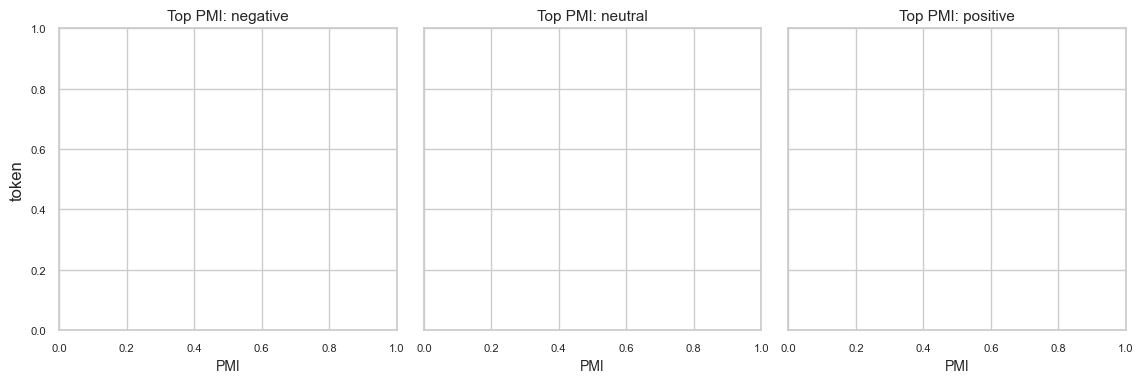

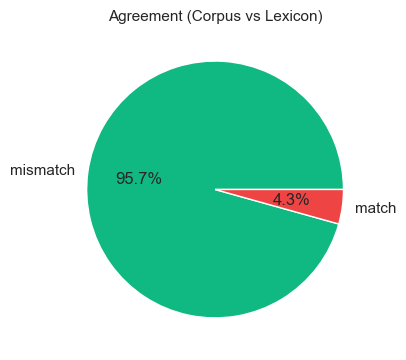

In [29]:
# === Cell J: Plots (top-K bars and pie chart)
import re
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook")  # balanced sizing

# ===Filter noisy tokens for neater charts ===
TOP_K_PLOT = 12        # how many bars per class to show
MIN_TOKEN_LEN = 3      # drop super-short items
EXCLUDE_PATTERNS = [r"^@", r"^#",
                    r"^https?://", r"\.com\b",  # urls
                    r"^\d+$"]                   # pure numbers

def looks_noisy(tok: str) -> bool:
    if tok is None: return True
    tok = str(tok).strip().lower()
    if len(tok) < MIN_TOKEN_LEN: return True
    if any(re.search(p, tok) for p in EXCLUDE_PATTERNS): return True
    return False

cands_clean = cands[~cands["token"].map(looks_noisy)].copy()

# NOTE: remove exact duplicates across classes keeping highest PMI
cands_clean = (cands_clean
               .sort_values("PMI", ascending=False)
               .drop_duplicates(subset=["token"], keep="first"))

# === Bar charts: top-K per label (negative / neutral / positive) ===
labels_in_order = ["negative", "neutral", "positive"]  # keeps columns aligned visually
fig, axes = plt.subplots(1, len(labels_in_order), figsize=(14, 4), sharey=True)

for ax, lbl in zip(axes, labels_in_order):
    sub = cands_clean[cands_clean["label"] == lbl]
    top = sub.nlargest(TOP_K_PLOT, "PMI").iloc[::-1]  # reverse so biggest is at top
    sns.barplot(data=top, x="PMI", y="token", ax=ax, color="#3b82f6")
    ax.set_title(f"Top PMI: {lbl}", fontsize=11)
    ax.set_xlabel("PMI", fontsize=10)
    ax.set_ylabel("token" if ax is axes[0] else "")
    # smaller ticklabels to avoid overlap
    ax.tick_params(axis="y", labelsize=8)
    ax.tick_params(axis="x", labelsize=8)

plt.tight_layout()
plt.subplots_adjust(left=0.22)  # more room for token labels
plt.savefig(RESULTS / "fig_top_pmi_terms.png", dpi=150)

#  ===Agreement pie (match vs mismatch)===
try:
    counts = merged_en["agreement"].value_counts(dropna=False)
    plt.figure(figsize=(4.2, 4.2))
    plt.pie(counts.values,
            labels=counts.index.astype(str),
            autopct="%1.1f%%",
            colors=["#10b981", "#ef4444", "#9ca3af"])
    plt.title("Agreement (Corpus vs Lexicon)", fontsize=11)
    plt.tight_layout()
    plt.savefig(RESULTS / "fig_agreement_pie.png", dpi=150)
    print("Saved figures →", RESULTS)
except Exception as e:
    print("Skipping pie chart (need merged_en):", e)

# Deliverables :
for p in [
    RESULTS/"pmi_candidates.csv",
    RESULTS/"pmi_terms_with_english.csv",
    RESULTS/"corpus_vs_lexicon_matches_enpivot.csv",
    RESULTS/"rag_review_queue_enpivot.csv",
    RESULTS/"fig_top_pmi_terms.png",
    RESULTS/"fig_agreement_pie.png",
]:
    print(("YES" if p.exists() else "NO"), p)

In [ ]:
import sys
!{sys.executable} -m pip install googletrans==4.0.0rc1 httpx==0.13.3 httpcore==0.9.1 textblob==0.17.1